# 2D Feature Extraction and Analysis

## 1. Configuration and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import time
from collections import OrderedDict, defaultdict
import math
import warnings

from skimage.feature import graycomatrix, graycoprops
from scipy.stats import skew, kurtosis
from scipy.fft import fft2, fftshift

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)


# --- Feature Extraction Parameters ---

# Stat Params
STAT_PERCENTILES = [10, 25, 75, 90]

# GLCM Params
GLCM_DISTANCES = [1, 3, 5]
GLCM_ANGLES_RAD = [0, np.pi/4, np.pi/2, 3*np.pi/4] # Radians for calculation
GLCM_ANGLES_DEG = [0, 45, 90, 135] # Degrees for naming convention
GLCM_PROPERTIES = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
GLCM_LEVELS = 256

# FFT Params
FFT_PERCENTILES = [10, 25, 50, 75, 90]


# --- Feature Extraction Functions ---

def calculate_statistical_features(matrix_2d, percentiles=STAT_PERCENTILES):
    features = OrderedDict()
    flat_matrix = matrix_2d.flatten()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        features['stat_mean'] = np.mean(matrix_2d)
        features['stat_std'] = np.std(matrix_2d)
        features['stat_variance'] = np.var(matrix_2d)
        features['stat_median'] = np.median(matrix_2d)
        features['stat_min'] = np.min(matrix_2d)
        features['stat_max'] = np.max(matrix_2d)
        features['stat_range'] = features['stat_max'] - features['stat_min'] if features['stat_max'] is not None and features['stat_min'] is not None else 0
        stat_std_val = features['stat_std']
        features['stat_skewness'] = skew(flat_matrix) if stat_std_val != 0 else 0
        features['stat_kurtosis'] = kurtosis(flat_matrix) if stat_std_val != 0 else -3
        features['stat_energy'] = np.sum(matrix_2d**2)
        features['stat_rms'] = np.sqrt(np.mean(matrix_2d**2))
        percentiles_values = np.percentile(flat_matrix, percentiles)
        for p, val in zip(percentiles, percentiles_values):
             features[f'stat_p{p}'] = val

        features['stat_iqr'] = features.get(f'stat_p{max(percentiles)}', np.nan) - features.get(f'stat_p{min(percentiles)}', np.nan) # Example: use min/max percentiles for IQR if 75/25 aren't guaranteed
        
        if f'stat_p75' in features and f'stat_p25' in features:
             features['stat_iqr'] = features['stat_p75'] - features['stat_p25']

    for key, value in features.items():
         if np.isnan(value):
             features[key] = 0.0
    return features

def get_stat_feature_names(percentiles=STAT_PERCENTILES):
    names = ['stat_mean', 'stat_std', 'stat_variance', 'stat_median', 'stat_min', 'stat_max',
             'stat_range', 'stat_skewness', 'stat_kurtosis', 'stat_energy', 'stat_rms']
    names.extend([f'stat_p{p}' for p in percentiles])
    names.append('stat_iqr')
    return names

def calculate_glcm_features(matrix_2d, distances=GLCM_DISTANCES, angles_rad=GLCM_ANGLES_RAD, angles_deg=GLCM_ANGLES_DEG, levels=GLCM_LEVELS, properties=GLCM_PROPERTIES):
    features = OrderedDict()
    min_val, max_val = np.min(matrix_2d), np.max(matrix_2d)
    if max_val == min_val:
        for prop in properties:
            for d in distances:
                for a_deg in angles_deg:
                    features[f'glcm_{prop}_d{d}_a{a_deg}'] = 0.0
        return features

    image_norm = matrix_2d - min_val
    image_norm = (image_norm / (max_val - min_val) * (levels - 1)).astype(np.uint8)

    try:
        glcm = graycomatrix(image_norm, distances=distances, angles=angles_rad, levels=levels, symmetric=True, normed=True)
        for i_d, d in enumerate(distances):
            for i_a, a_deg in enumerate(angles_deg):
                for prop in properties:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=UserWarning)
                        prop_value = graycoprops(glcm[i_d:i_d+1, i_a:i_a+1, :, :], prop)[0, 0]
                        feature_name = f'glcm_{prop}_d{d}_a{a_deg}'
                        features[feature_name] = 0.0 if np.isnan(prop_value) else prop_value
    except ValueError as e:
         print(f"Warning: GLCM calculation failed for an image patch: {e}. Returning zeros.")
         expected_names = get_glcm_feature_names(distances, angles_deg, properties)
         for name in expected_names:
             if name not in features:
                 features[name] = 0.0
    return features


def get_glcm_feature_names(distances=GLCM_DISTANCES, angles_deg=GLCM_ANGLES_DEG, properties=GLCM_PROPERTIES):
    names = []
    for prop in properties:
        for d in distances:
            for a_deg in angles_deg:
                names.append(f'glcm_{prop}_d{d}_a{a_deg}')
    return names

def calculate_fft_features(matrix_2d, percentiles=FFT_PERCENTILES):
    features = OrderedDict()
    try:
        fft_result = fft2(matrix_2d)
        fft_shifted = fftshift(fft_result)
        magnitude_spectrum = np.abs(fft_shifted)
        magnitude_flat = magnitude_spectrum.flatten()

        features['fft_mean_magnitude'] = np.mean(magnitude_spectrum)
        features['fft_std_magnitude'] = np.std(magnitude_spectrum)
        features['fft_max_magnitude'] = np.max(magnitude_spectrum)
        features['fft_min_magnitude'] = np.min(magnitude_spectrum)

        center_row, center_col = magnitude_spectrum.shape[0] // 2, magnitude_spectrum.shape[1] // 2
        features['fft_dc_magnitude'] = magnitude_spectrum[center_row, center_col]

        magnitude_no_dc = magnitude_spectrum.copy()
        magnitude_no_dc[center_row, center_col] = 0
        features['fft_mean_magnitude_no_dc'] = np.mean(magnitude_no_dc)
        features['fft_std_magnitude_no_dc'] = np.std(magnitude_no_dc)

        features['fft_spectral_energy'] = np.sum(magnitude_spectrum**2)

        percentile_values = np.percentile(magnitude_flat, percentiles)
        for p, val in zip(percentiles, percentile_values):
            features[f'fft_mag_p{p}'] = val

    except Exception as e:
        print(f"Warning: FFT calculation failed: {e}. Returning zeros.")
        expected_names = get_fft_feature_names(percentiles)
        for name in expected_names:
            features[name] = 0.0

    for key, value in features.items():
         if np.isnan(value):
             features[key] = 0.0
    return features

def get_fft_feature_names(percentiles=FFT_PERCENTILES):
    names = [
        'fft_mean_magnitude', 'fft_std_magnitude', 'fft_max_magnitude', 'fft_min_magnitude',
        'fft_dc_magnitude', 'fft_mean_magnitude_no_dc', 'fft_std_magnitude_no_dc',
        'fft_spectral_energy'
    ]
    names.extend([f'fft_mag_p{p}' for p in percentiles])
    return names

print("Feature extraction functions defined.")

Feature extraction functions defined.


In [2]:
# --- General Parameters ---
IMG_ROWS = 72
IMG_COLS = 48
NUM_FEATURES_ORIGINAL = IMG_ROWS * IMG_COLS
SEED = 42
np.random.seed(SEED)

try:
    BASE_DATA_DIR = Path('../data/processed/')
    if not BASE_DATA_DIR.exists():
         print("Warning: '../data/processed/' not found. Looking for data in current directory.")
         BASE_DATA_DIR = Path('./')
    TRAIN_CSV_PATH = BASE_DATA_DIR / 'train_processed.csv'
    OUTPUT_DIR = Path('./engineered_features_extract')
    OUTPUT_DIR.mkdir(exist_ok=True)
    FEATURES_OUTPUT_CSV = OUTPUT_DIR / 'engineered_features_train.csv'
    ANALYSIS_SUMMARY_FILE = OUTPUT_DIR / 'feature_analysis_summary.txt'
except Exception as e:
    print(f"Error setting up paths: {e}")
    raise

# --- Analysis Parameters ---
N_TOP_FEATURES_ANALYSIS = 25
N_TOP_FOR_SUMMARY = 5

# --- Dynamically Generate Feature Names ---
stat_feature_names = get_stat_feature_names(STAT_PERCENTILES)
glcm_feature_names = get_glcm_feature_names(GLCM_DISTANCES, GLCM_ANGLES_DEG, GLCM_PROPERTIES)
fft_feature_names = get_fft_feature_names(FFT_PERCENTILES)

calculated_feature_names = stat_feature_names + glcm_feature_names + fft_feature_names
n_features_expected = len(calculated_feature_names)

print(f"Train CSV Path: {TRAIN_CSV_PATH}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Target output file: {FEATURES_OUTPUT_CSV}")
print(f"Number of features to be calculated: {n_features_expected}")

Train CSV Path: ..\data\processed\train_processed.csv
Output Directory: engineered_features_extract
Target output file: engineered_features_extract\engineered_features_train.csv
Number of features to be calculated: 101


## 2. Data Loading and Reshaping


Loading data from: ..\data\processed\train_processed.csv
Data loaded: 1491 samples, 3458 columns.

Reshaping into 72x48 images...
Reshaping finished. Shape of X_train_2d: (1491, 72, 48)


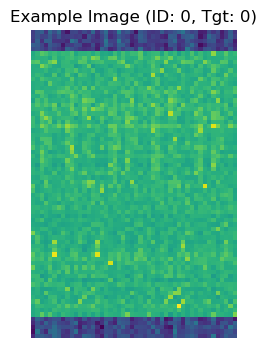

In [3]:
print(f"\nLoading data from: {TRAIN_CSV_PATH}")
if not TRAIN_CSV_PATH.is_file():
    raise FileNotFoundError(f"File {TRAIN_CSV_PATH} not found. Please check the path.")

try:
    feature_cols_original = [f'f_{i}' for i in range(NUM_FEATURES_ORIGINAL)]
    cols_to_load = ['ID', 'target'] + feature_cols_original
    df_train = pd.read_csv(TRAIN_CSV_PATH, usecols=cols_to_load)
    print(f"Data loaded: {df_train.shape[0]} samples, {df_train.shape[1]} columns.")
except Exception as e:
    print(f"Error loading CSV: {e}")
    raise

train_ids = df_train['ID'].values
y_train = df_train['target'].values
X_train_flat = df_train[feature_cols_original].values

print(f"\nReshaping into {IMG_ROWS}x{IMG_COLS} images...")
if X_train_flat.shape[1] != NUM_FEATURES_ORIGINAL:
    raise ValueError(f"Incorrect number of features: {X_train_flat.shape[1]} vs {NUM_FEATURES_ORIGINAL}")
try:
    X_train_2d = X_train_flat.reshape(-1, IMG_ROWS, IMG_COLS)
    print(f"Reshaping finished. Shape of X_train_2d: {X_train_2d.shape}")
except Exception as e:
     print(f"Error reshaping data: {e}")
     raise

plt.figure(figsize=(3, 4))
plt.imshow(X_train_2d[0], cmap='viridis')
plt.title(f"Example Image (ID: {train_ids[0]}, Tgt: {y_train[0]})")
plt.axis('off')
plt.show()

## 3. Feature Extraction

In [4]:
all_extracted_features_list = []

print("\nStarting feature extraction for all samples...")
start_time_extraction = time.time()

try:
    from tqdm import tqdm as tqdm_std
    tqdm_iterator = tqdm(range(len(X_train_2d)), desc="Extracting Features")
except ImportError:
    tqdm_iterator = tqdm_std(range(len(X_train_2d)), desc="Extracting Features")

for i in tqdm_iterator:
    img = X_train_2d[i]

    stat_features = calculate_statistical_features(img, STAT_PERCENTILES)
    glcm_features = calculate_glcm_features(img, GLCM_DISTANCES, GLCM_ANGLES_RAD, GLCM_ANGLES_DEG, GLCM_LEVELS, GLCM_PROPERTIES)
    fft_features = calculate_fft_features(img, FFT_PERCENTILES)

    all_calculated_features_dict = {**stat_features, **glcm_features, **fft_features}

    sample_features_ordered = []
    for feature_name in calculated_feature_names:
        sample_features_ordered.append(all_calculated_features_dict.get(feature_name, np.nan))

    if len(sample_features_ordered) != n_features_expected:
         print(f"\nWarning: Mismatch in feature count for sample {i}. Expected {n_features_expected}, got {len(sample_features_ordered)}. Check extraction functions and get_*_names functions.")

         sample_features_ordered.extend([np.nan] * (n_features_expected - len(sample_features_ordered)))


    all_extracted_features_list.append(sample_features_ordered)


end_time_extraction = time.time()
print(f"\nExtraction finished in {end_time_extraction - start_time_extraction:.2f} seconds.")

X_engineered_combined = pd.DataFrame(all_extracted_features_list, columns=calculated_feature_names)

print(f"\nFinal shape of combined features DataFrame (before adding ID/Target): {X_engineered_combined.shape}")
print(f"Total number of extracted features: {X_engineered_combined.shape[1]}")

nan_counts = X_engineered_combined.isnull().sum()
inf_counts = np.isinf(X_engineered_combined).sum()

if nan_counts.sum() > 0 or inf_counts.sum() > 0:
    print("\nWarning: NaN or Inf values detected in extracted features!")
    print("NaN counts per column:\n", nan_counts[nan_counts > 0])
    print("Inf counts per column:\n", inf_counts[inf_counts > 0])
    print("Filling NaN/Inf values with column means...")
    col_means = X_engineered_combined.mean()
    X_engineered_combined.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_engineered_combined.fillna(col_means, inplace=True)

    if X_engineered_combined.isnull().sum().sum() == 0 and np.isinf(X_engineered_combined).sum().sum() == 0:
         print("NaN/Inf values successfully replaced with means.")
    else:
         print("Warning: Some NaN/Inf values might still be present after filling.")
         print("Remaining NaN counts:\n", X_engineered_combined.isnull().sum()[X_engineered_combined.isnull().sum() > 0])
         print("Remaining Inf counts:\n", np.isinf(X_engineered_combined).sum()[np.isinf(X_engineered_combined).sum() > 0])
else:
    print("\nNo NaN or Inf values detected in extracted features.")


print(f"\nSaving engineered features to: {FEATURES_OUTPUT_CSV}")
try:
    df_engineered_output = X_engineered_combined.copy()

    df_engineered_output.insert(0, 'ID', train_ids)
    df_engineered_output.insert(1, 'Target', y_train)

    final_columns_expected = ['ID', 'Target'] + calculated_feature_names
    if list(df_engineered_output.columns) != final_columns_expected:
        print("Warning: Column order mismatch detected before saving. Reordering...")
        try:
            df_engineered_output = df_engineered_output[final_columns_expected]
        except KeyError as e:
            print(f"Error: Could not reorder columns. Missing columns: {e}")

            missing_cols = set(final_columns_expected) - set(df_engineered_output.columns)
            extra_cols = set(df_engineered_output.columns) - set(final_columns_expected)
            print(f"Missing: {missing_cols}")
            print(f"Extra: {extra_cols}")
            raise

    df_engineered_output.to_csv(FEATURES_OUTPUT_CSV, index=False)
    print(f"Engineered features saved successfully with dynamically determined columns: {df_engineered_output.shape}")
except Exception as e:
    print(f"Error saving engineered features CSV: {e}")


Starting feature extraction for all samples...


Extracting Features:   0%|          | 0/1491 [00:00<?, ?it/s]


Extraction finished in 18.32 seconds.

Final shape of combined features DataFrame (before adding ID/Target): (1491, 101)
Total number of extracted features: 101

No NaN or Inf values detected in extracted features.

Saving engineered features to: engineered_features_extract\engineered_features_train.csv
Engineered features saved successfully with dynamically determined columns: (1491, 103)


## 4. Exploratory Analysis of Combined Features

In [5]:
X_analysis = X_engineered_combined.values
feature_names_analysis = calculated_feature_names


Applying StandardScaler to combined features...
Scaling finished.

Calculating Global Feature Importance (ExtraTrees)...
ExtraTrees importance calculated in 0.14s.

Calculating Global Feature Importance (SelectKBest - f_classif)...
SelectKBest f_classif scores calculated in 0.00s.

--- Analyzing: Basic Statistics Features ---
Found 16 features.


C:\Users\redh0\.conda\envs\Privacy_Preserving_Face_Recognition_Project\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


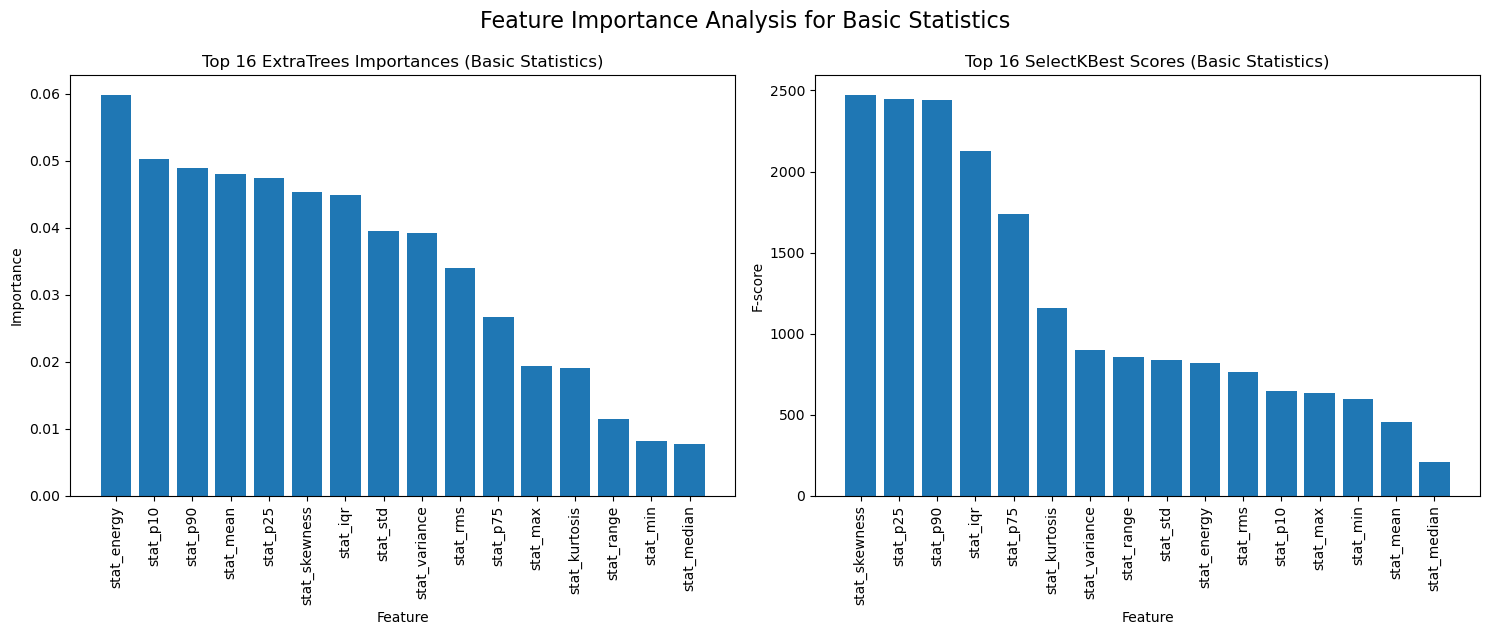


--- Analyzing: GLCM Features ---
Found 72 features.


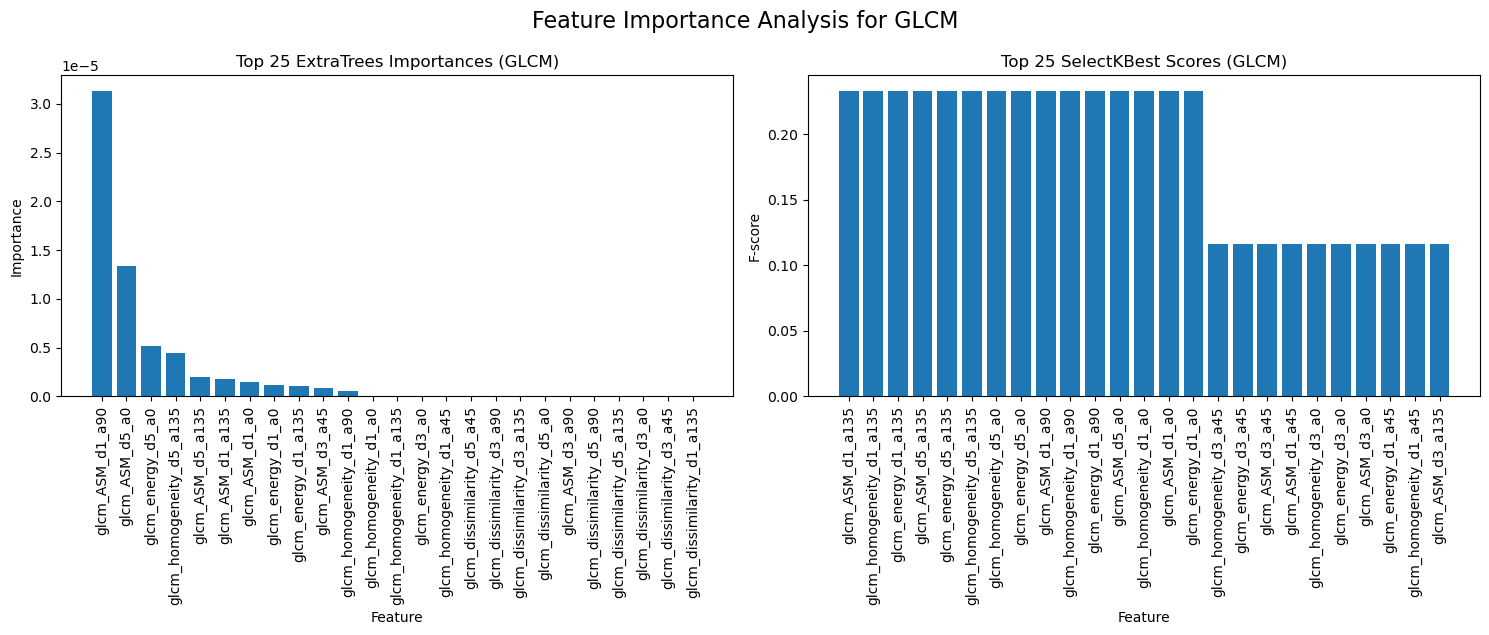


--- Analyzing: FFT Magnitude Features ---
Found 13 features.


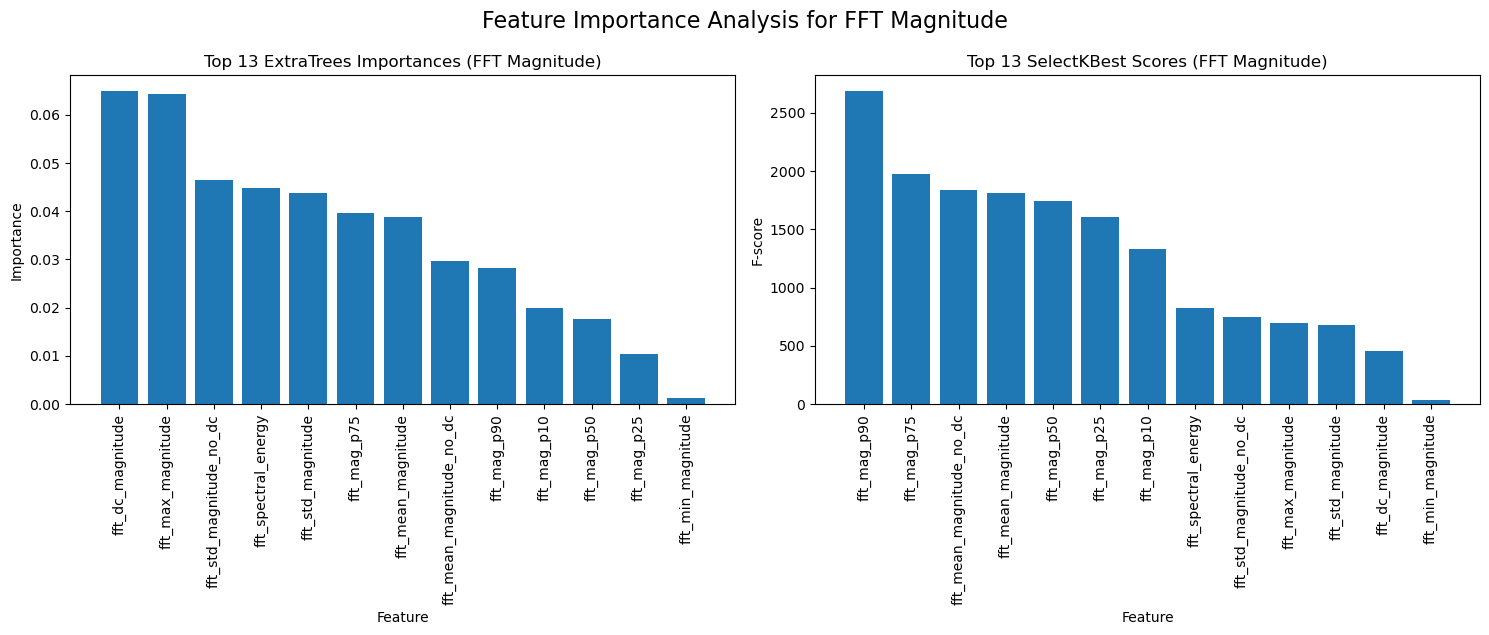



--- Feature Analysis Summary (Based on Dynamically Calculated Features) ---
Feature Analysis Summary (Based on Dynamically Calculated Features):

--- Global Top 5 Features ---
ExtraTrees Importance:
  1. fft_dc_magnitude: 0.0650
  2. fft_max_magnitude: 0.0643
  3. stat_energy: 0.0598
  4. stat_p10: 0.0502
  5. stat_p90: 0.0490

SelectKBest (f_classif) Score:
  1. fft_mag_p90: 2686.9435
  2. stat_skewness: 2469.7680
  3. stat_p25: 2445.5857
  4. stat_p90: 2443.4670
  5. stat_iqr: 2127.5090
--------------------

--- Basic Statistics Features (16 total defined) ---
  Mean ExtraTrees Importance: 0.0344
  Mean SelectKBest Score:   1194.1286

  Top 5 ExtraTrees Importance:
    - stat_energy: 0.0598
    - stat_p10: 0.0502
    - stat_p90: 0.0490
    - stat_mean: 0.0480
    - stat_p25: 0.0475

  Top 5 SelectKBest (f_classif) Score:
    - stat_skewness: 2469.7680
    - stat_p25: 2445.5857
    - stat_p90: 2443.4670
    - stat_iqr: 2127.5090
    - stat_p75: 1738.5922
--------------------

--- GL

In [6]:
# --- 4.1 Feature Scaling ---
print("\nApplying StandardScaler to combined features...")
scaler = StandardScaler()
try:
    X_scaled = scaler.fit_transform(X_analysis)
    print("Scaling finished.")
except ValueError as e:
    print(f"Error during scaling: {e}. Checking for constant columns...")
    variances = np.var(X_analysis, axis=0)
    constant_cols_indices = np.where(variances == 0)[0]
    if len(constant_cols_indices) > 0:
        constant_col_names = [feature_names_analysis[i] for i in constant_cols_indices]
        print(f"Constant columns found (zero variance): {constant_col_names}")
        print("Consider removing these columns or handling them before scaling.")
    else:
         print("No constant columns identified, scaling error might be due to other reasons (e.g., all NaNs).")

    if 'X_scaled' not in locals() or X_scaled.shape != X_analysis.shape:
         print("Using unscaled data for importance calculation due to scaling issues.")
         X_scaled = X_analysis # Fallback to unscaled

except Exception as e:
    print(f"Unexpected error during scaling: {e}. Using unscaled data.")
    X_scaled = X_analysis # Fallback to unscaled


if X_scaled.shape[1] == 0:
    print("\nSkipping feature importance analysis as there are no features left after potential filtering.")
else:
    # --- 4.2 Global Feature Importance ---
    print("\nCalculating Global Feature Importance (ExtraTrees)...")
    start_time_et = time.time()
    et_classifier = ExtraTreesClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    et_classifier.fit(X_scaled, y_train)
    et_importances = et_classifier.feature_importances_
    et_indices = np.argsort(et_importances)[::-1]
    et_time = time.time() - start_time_et
    print(f"ExtraTrees importance calculated in {et_time:.2f}s.")

    print("\nCalculating Global Feature Importance (SelectKBest - f_classif)...")
    start_time_skb_f = time.time()
    k_best_f = min(N_TOP_FEATURES_ANALYSIS * 3, X_scaled.shape[1])
    selector_f = SelectKBest(score_func=f_classif, k=k_best_f)

    variances = np.var(X_scaled, axis=0)
    if np.any(variances == 0):
        print("Warning: Zero variance columns detected in scaled data before SelectKBest. Scores for these columns will be NaN/zero.")
    selector_f.fit(X_scaled, y_train)
    skb_f_scores = selector_f.scores_
    skb_f_scores = np.nan_to_num(skb_f_scores, nan=0.0)
    skb_f_indices = np.argsort(skb_f_scores)[::-1]
    skb_f_time = time.time() - start_time_skb_f
    print(f"SelectKBest f_classif scores calculated in {skb_f_time:.2f}s.")

    # --- 4.3 Analysis per Feature Group ---
    feature_groups = defaultdict(list)
    for i, name in enumerate(feature_names_analysis):
        if name.startswith('stat_'):
            feature_groups['Basic Statistics'].append(i)
        elif name.startswith('glcm_'):
            feature_groups['GLCM'].append(i)
        elif name.startswith('fft_'):
            feature_groups['FFT Magnitude'].append(i)
        else:
            feature_groups['Other'].append(i)

    analysis_results = {}

    for group_name, group_indices in feature_groups.items():
        valid_group_indices = [idx for idx in group_indices if idx < X_scaled.shape[1]]

        if not valid_group_indices:
            print(f"\n--- Skipping Analysis for Group: {group_name} (No valid features found) ---")
            continue

        print(f"\n--- Analyzing: {group_name} Features ---")
        print(f"Found {len(valid_group_indices)} features.")
        analysis_results[group_name] = {}

        group_et_importances = et_importances[valid_group_indices]
        group_et_indices_rel = np.argsort(group_et_importances)[::-1]
        group_et_indices_abs = [valid_group_indices[i] for i in group_et_indices_rel]

        analysis_results[group_name]['Mean_ET_Importance'] = np.mean(group_et_importances)
        analysis_results[group_name]['Top_ET_Features'] = OrderedDict(zip(
            [feature_names_analysis[i] for i in group_et_indices_abs[:N_TOP_FEATURES_ANALYSIS]],
            et_importances[group_et_indices_abs[:N_TOP_FEATURES_ANALYSIS]]
        ))

        group_skb_f_scores = skb_f_scores[valid_group_indices]
        group_skb_f_indices_rel = np.argsort(group_skb_f_scores)[::-1]
        group_skb_f_indices_abs = [valid_group_indices[i] for i in group_skb_f_indices_rel]

        analysis_results[group_name]['Mean_SelectKBest_Score'] = np.mean(group_skb_f_scores)
        analysis_results[group_name]['Top_SelectKBest_Features'] = OrderedDict(zip(
            [feature_names_analysis[i] for i in group_skb_f_indices_abs[:N_TOP_FEATURES_ANALYSIS]],
            skb_f_scores[group_skb_f_indices_abs[:N_TOP_FEATURES_ANALYSIS]]
        ))

        plt.figure(figsize=(15, 6))
        top_n = min(N_TOP_FEATURES_ANALYSIS, len(valid_group_indices))

        plt.subplot(1, 2, 1)
        plt.bar(range(top_n), et_importances[group_et_indices_abs[:top_n]], align='center')
        plt.xticks(range(top_n), [feature_names_analysis[i] for i in group_et_indices_abs[:top_n]], rotation=90)
        plt.title(f'Top {top_n} ExtraTrees Importances ({group_name})')
        plt.ylabel('Importance')
        plt.xlabel('Feature')
        plt.tight_layout()

        plt.subplot(1, 2, 2)
        plt.bar(range(top_n), skb_f_scores[group_skb_f_indices_abs[:top_n]], align='center')
        plt.xticks(range(top_n), [feature_names_analysis[i] for i in group_skb_f_indices_abs[:top_n]], rotation=90)
        plt.title(f'Top {top_n} SelectKBest Scores ({group_name})')
        plt.ylabel('F-score')
        plt.xlabel('Feature')
        plt.tight_layout()

        plt.suptitle(f"Feature Importance Analysis for {group_name}", fontsize=16, y=1.05)
        plt.show()


    # --- 4.4 Summary of Analysis ---
    print("\n\n--- Feature Analysis Summary (Based on Dynamically Calculated Features) ---")

    summary_text = "Feature Analysis Summary (Based on Dynamically Calculated Features):\n\n"

    # Global Top Features
    summary_text += f"--- Global Top {N_TOP_FOR_SUMMARY} Features ---\n"
    summary_text += f"ExtraTrees Importance:\n"
    for i in range(min(N_TOP_FOR_SUMMARY, len(feature_names_analysis))):
        summary_text += f"  {i+1}. {feature_names_analysis[et_indices[i]]}: {et_importances[et_indices[i]]:.4f}\n"
    summary_text += f"\nSelectKBest (f_classif) Score:\n"
    for i in range(min(N_TOP_FOR_SUMMARY, len(feature_names_analysis))):
        summary_text += f"  {i+1}. {feature_names_analysis[skb_f_indices[i]]}: {skb_f_scores[skb_f_indices[i]]:.4f}\n"
    summary_text += "-" * 20 + "\n\n"


    # Per-Group Top Features
    for group_name, group_data in analysis_results.items():
        num_features_in_group = len(feature_groups[group_name])
        summary_text += f"--- {group_name} Features ({num_features_in_group} total defined) ---\n"
        summary_text += f"  Mean ExtraTrees Importance: {group_data.get('Mean_ET_Importance', 'N/A'):.4f}\n"
        summary_text += f"  Mean SelectKBest Score:   {group_data.get('Mean_SelectKBest_Score', 'N/A'):.4f}\n"

        summary_text += f"\n  Top {N_TOP_FOR_SUMMARY} ExtraTrees Importance:\n"
        top_et_features = group_data.get('Top_ET_Features')
        if top_et_features:
            count = 0
            for feature, importance in top_et_features.items():
                if count >= N_TOP_FOR_SUMMARY: break
                summary_text += f"    - {feature}: {importance:.4f}\n"
                count += 1
        else:
             summary_text += "    (No data or group skipped)\n"

        summary_text += f"\n  Top {N_TOP_FOR_SUMMARY} SelectKBest (f_classif) Score:\n"
        top_skb_features = group_data.get('Top_SelectKBest_Features')
        if top_skb_features:
            count = 0
            for feature, score in top_skb_features.items():
                if count >= N_TOP_FOR_SUMMARY: break
                summary_text += f"    - {feature}: {score:.4f}\n"
                count += 1
        else:
             summary_text += "    (No data or group skipped)\n"

        summary_text += "-" * 20 + "\n\n"

    print(summary_text)


    print(f"\nSaving analysis summary to: {ANALYSIS_SUMMARY_FILE}")
    try:
        with open(ANALYSIS_SUMMARY_FILE, 'w') as f:
            f.write(summary_text)
        print(f"Analysis summary saved successfully.")
    except Exception as e:
        print(f"\nError saving analysis summary: {e}")

## Noise suppression : correlation redundancy and low variance

In [7]:
import numpy as np
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
df_all_features = pd.read_csv("engineered_features_extract/engineered_features_train.csv")
df_all_features

,ID,Target,stat_mean,stat_std,stat_variance,stat_median,stat_min,stat_max,stat_range,stat_skewness,...,fft_min_magnitude,fft_dc_magnitude,fft_mean_magnitude_no_dc,fft_std_magnitude_no_dc,fft_spectral_energy,fft_mag_p10,fft_mag_p25,fft_mag_p50,fft_mag_p75,fft_mag_p90
0,0,0,-3.869953,15.390045,236.853473,0.242973,-60.063696,35.168647,95.232343,-1.802966,...,7.446459,13374.558886,319.673822,846.388947,3.007842e+09,82.931942,135.423931,217.389424,323.833783,477.718720
1,1,0,-3.665838,15.280553,233.495287,0.148352,-59.162244,32.086281,91.248525,-1.793593,...,4.043500,12669.135070,328.735223,835.998124,2.949360e+09,86.285019,146.530621,224.030466,337.957804,491.178129
2,10,2,-4.689862,17.006326,289.215125,0.309707,-62.956007,31.792782,94.748788,-1.915893,...,12.232763,16208.163196,337.292624,941.148850,3.717071e+09,91.513341,159.856399,248.712133,345.020794,443.084322
3,100,0,-3.657678,16.489984,271.919563,0.647368,-61.453326,41.603306,103.056632,-1.776796,...,7.619595,12640.934704,353.397336,902.698361,3.407583e+09,89.363529,153.841984,250.061159,352.695752,531.450873
4,1000,0,-3.807691,15.991054,255.713816,0.365211,-57.937959,40.949059,98.887018,-1.820411,...,5.286731,13159.378757,331.225613,879.793465,3.227399e+09,85.985664,137.754575,214.303066,336.101287,491.873857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,995,0,-3.682093,16.226140,263.287621,0.484342,-60.957192,31.766429,92.723621,-1.755624,...,10.021986,12725.312495,353.894235,885.822154,3.306624e+09,91.227917,150.284294,245.343539,369.577631,528.538090
1487,996,0,-3.591107,16.460267,270.940397,0.574235,-60.811862,34.347756,95.159619,-1.759480,...,11.030155,12410.866652,354.747645,900.291130,3.390124e+09,88.964134,152.292610,244.249917,359.355506,524.652114
1488,997,0,-3.830479,16.154153,260.956674,0.520650,-62.346879,26.029869,88.376748,-1.819159,...,7.410712,13238.135304,335.069872,888.591270,3.292098e+09,87.350846,141.697638,228.067611,342.664882,486.453925
1489,998,0,-3.808672,16.116265,259.733988,0.342546,-59.803209,32.262067,92.065276,-1.797523,...,7.321894,13162.769859,337.541899,885.271783,3.275505e+09,83.784965,142.025348,229.068361,347.807800,503.630965


In [9]:
VARIANCE_THRESHOLD_VALUE = 0.01
CORRELATION_THRESHOLD_VALUE = 0.95
TARGET_COLUMN = 'Target'
ID_COLUMN = 'ID'

In [10]:
feature_columns = df_all_features.columns.drop([TARGET_COLUMN] + ([ID_COLUMN] if ID_COLUMN else []))
X = df_all_features[feature_columns]
y = df_all_features[TARGET_COLUMN]
ids = df_all_features[[ID_COLUMN]] if ID_COLUMN and ID_COLUMN in df_all_features.columns else None

print(f"Initial number of features : {X.shape[1]}")

Initial number of features : 101


In [11]:
if X.isnull().sum().sum() > 0:
    print(f"\nDetection of {X.isnull().sum().sum()} NaN values. Imputation by mean...")
    X = X.fillna(X.mean())
    if X.isnull().sum().sum() > 0:
         print("Warning : ersistent NaNs after mean imputation. Check the columns.")
    else:
        print("NaNs imputation finished.")
else:
    print("\nNo NaN value detected in the features.")


No NaN value detected in the features.


### Removing low variance features

In [12]:
print(f"\nApplication of the variance threshold (nthreshold = {VARIANCE_THRESHOLD_VALUE})...")
selector_var = VarianceThreshold(threshold=VARIANCE_THRESHOLD_VALUE)

try:
    selector_var.fit(X)
    features_to_keep_var = X.columns[selector_var.get_support()]
    features_to_remove_var = X.columns[~selector_var.get_support()]

    if len(features_to_remove_var) > 0:
        print(f"Suppression de {len(features_to_remove_var)} caractéristiques à faible variance :")
        print(features_to_remove_var.tolist())
        X = X[features_to_keep_var] # Garder uniquement les colonnes sélectionnées
    else:
        print("No features deleted by the threshold of variance.")

    print(f"Number of features after variance filter : {X.shape[1]}")

except ValueError as e:
    print(f"Error while applying variance threshold : {e}")
    print("Check for NaNs or non-numeric data types remaining.")


Application of the variance threshold (nthreshold = 0.01)...
Suppression de 72 caractéristiques à faible variance :
['glcm_contrast_d1_a0', 'glcm_contrast_d1_a45', 'glcm_contrast_d1_a90', 'glcm_contrast_d1_a135', 'glcm_contrast_d3_a0', 'glcm_contrast_d3_a45', 'glcm_contrast_d3_a90', 'glcm_contrast_d3_a135', 'glcm_contrast_d5_a0', 'glcm_contrast_d5_a45', 'glcm_contrast_d5_a90', 'glcm_contrast_d5_a135', 'glcm_dissimilarity_d1_a0', 'glcm_dissimilarity_d1_a45', 'glcm_dissimilarity_d1_a90', 'glcm_dissimilarity_d1_a135', 'glcm_dissimilarity_d3_a0', 'glcm_dissimilarity_d3_a45', 'glcm_dissimilarity_d3_a90', 'glcm_dissimilarity_d3_a135', 'glcm_dissimilarity_d5_a0', 'glcm_dissimilarity_d5_a45', 'glcm_dissimilarity_d5_a90', 'glcm_dissimilarity_d5_a135', 'glcm_homogeneity_d1_a0', 'glcm_homogeneity_d1_a45', 'glcm_homogeneity_d1_a90', 'glcm_homogeneity_d1_a135', 'glcm_homogeneity_d3_a0', 'glcm_homogeneity_d3_a45', 'glcm_homogeneity_d3_a90', 'glcm_homogeneity_d3_a135', 'glcm_homogeneity_d5_a0', 'glc

### Removing highly correlated features

In [13]:
print(f"\nApplication of the correlation threshold (threshold = {CORRELATION_THRESHOLD_VALUE})...")

corr_matrix = X.corr().abs()

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

columns_to_drop_corr = [column for column in upper_tri.columns if any(upper_tri[column] > CORRELATION_THRESHOLD_VALUE)]

if len(columns_to_drop_corr) > 0:
    print(f"Removing {len(columns_to_drop_corr)} highly correlated features :")
    print(sorted(columns_to_drop_corr)) # Trié pour la lisibilité
    X = X.drop(columns=columns_to_drop_corr)
else:
    print("No features removed by correlation threshold.")

print(f"Number of features after correlation filter : {X.shape[1]}")


Application of the correlation threshold (threshold = 0.95)...
Removing 20 highly correlated features :
['fft_dc_magnitude', 'fft_mag_p25', 'fft_mag_p50', 'fft_mag_p75', 'fft_mag_p90', 'fft_max_magnitude', 'fft_mean_magnitude', 'fft_mean_magnitude_no_dc', 'fft_spectral_energy', 'fft_std_magnitude', 'fft_std_magnitude_no_dc', 'stat_energy', 'stat_iqr', 'stat_kurtosis', 'stat_p10', 'stat_p25', 'stat_p90', 'stat_range', 'stat_rms', 'stat_variance']
Number of features after correlation filter : 9


-----

In [16]:
to_concat = []
if 'ids' in locals() and ids is not None:
    to_concat.append(ids.reset_index(drop=True))

y_df = y.to_frame(name=TARGET_COLUMN) if isinstance(y, pd.Series) else y
to_concat.append(y_df.reset_index(drop=True))

to_concat.append(X.reset_index(drop=True))

df_final_output = pd.concat(to_concat, axis=1)

print(f"\nShape of the final DataFrame to be saved : {df_final_output.shape}")
df_final_output.describe()


Shape of the final DataFrame to be saved : (1491, 11)


,ID,Target,stat_mean,stat_std,stat_median,stat_min,stat_max,stat_skewness,stat_p75,fft_min_magnitude,fft_mag_p10
count,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000,1491.000000
mean,745.000000,0.283702,-3.864041,15.708997,0.347042,-59.115527,34.310291,-1.843536,3.792849,5.473340,85.213765
std,430.558939,0.626589,0.392561,1.747227,0.229236,4.794229,8.752170,0.154533,0.986551,3.055172,12.055582
min,0.000000,0.000000,-5.314607,7.073056,-0.263585,-66.495126,1.454189,-2.592492,0.105836,0.007118,36.535288
25%,372.500000,0.000000,-3.897715,15.453091,0.174988,-61.369404,31.398110,-1.832047,3.583335,3.136644,82.914018
50%,745.000000,0.000000,-3.786145,16.106070,0.371401,-59.929569,34.776332,-1.798131,4.018986,5.156769,87.557855
75%,1117.500000,0.000000,-3.687964,16.357351,0.514632,-58.457018,38.799687,-1.776560,4.347969,7.344436,91.613967
max,1490.000000,2.000000,-2.607821,18.695312,1.067489,-33.461717,76.529848,-1.688397,5.293152,20.301208,110.488300
